# Regressed Feature Comparison

## Import

### Import modules

In [1]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from rep.estimators import XGBoostClassifier
import root_numpy
import time
from __future__ import division
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
import sys
sys.path.append('../')
from MPPlot import *
from Regression_Application import *

Couldn't import dot_parser, loading of dot files will not be possible.


Welcome to ROOTaaS 6.06/04


/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/root_numpy/__init__.py:35: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.11.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [ ]:
mode = "mu_tau_b_b"
dataVersion = "v1"
signalData = pandas.DataFrame(root_numpy.root2array("/home/giles/cernbox/sample_analysis/MG5_pp_hh_bbtt_13TeV_10M_py8_" + dataVersion + ".root", treename = mode))
backgroundData = pandas.DataFrame(root_numpy.root2array("/home/giles/cernbox/sample_analysis/PH_pp_tt_ll_13Tev_10M_py8_" + "v1" + ".root", treename = mode))
print "Samples contains", len(signalData), "signal events and", len(backgroundData), "background events"
print len(signalData)+len(backgroundData), "events in total"

## Configure data

### Add classification targets and combine into single dataset

In [ ]:
signalData["gen_target"] = 1
backgroundData["gen_target"] = 0
data = signalData.append(backgroundData, ignore_index = True)

In [ ]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
rename = [var for var in data.columns if str.endswith(var, "_e")]
data.rename(columns=dict(zip(rename, [var[:var.rfind("_e")] + "_E" for var in rename])), inplace=True)
rename = [var for var in data.columns if str.startswith(var, "gen_hh")]
data.rename(columns=dict(zip(rename, ["gen_diH" + var[6:] for var in rename])), inplace=True)
data.rename(columns={'gen_m_hh' : 'gen_diH_mass'}, inplace=True)

### Move to cartesian coordinates

In [ ]:
def moveToCartesian(inData, particle, z = True):
    pt = inData.ix[:, particle + "_pT"]
    if z: eta = inData.ix[:, particle + "_eta"]
    phi = inData.ix[:, particle + "_phi"]
    inData[particle + '_px'] = pt*np.cos(phi)
    inData[particle + '_py'] = pt*np.sin(phi)
    if z: inData[particle + '_pz'] = pt*np.sinh(eta)

In [ ]:
moveToCartesian(data, 'gen_t_0')
moveToCartesian(data, 'gen_t_1')
moveToCartesian(data, 'gen_b_0')
moveToCartesian(data, 'gen_b_1')
moveToCartesian(data, 'gen_h_tt')
moveToCartesian(data, 'gen_h_bb')
moveToCartesian(data, 'gen_diH')
moveToCartesian(data, 't_0')
moveToCartesian(data, 't_1')
moveToCartesian(data, 'b_0')
moveToCartesian(data, 'b_1')
moveToCartesian(data, 'h_tt')
moveToCartesian(data, 'h_bb')
moveToCartesian(data, 'diH')
moveToCartesian(data, 'mPT', False)

### High-level variables

In [ ]:
def deltaphi(a, b):
    return math.pi-np.abs(np.abs(a-b)-math.pi)

In [ ]:
finalStates = ['b_0', 'b_1', 't_0', 't_1']
recoObjects = ['diH', 'h_bb', 'h_tt']
variables = ['px', 'py', 'pz']
for fs1 in finalStates:
    for fs2 in finalStates:
        if fs1 == fs2: continue
        for var in variables:
            data['hl_d' + var + '_' + fs1 + '_' + fs2] = data.ix[:, fs1 + '_' + var] - data.ix[:, fs2 + '_' + var]
    data['hl_dpx_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_px'] - data.ix[:, 'mPT_px']
    data['hl_dpy_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_py'] - data.ix[:, 'mPT_py']
    data[fs1 + '_|p|'] = np.sqrt(np.square(data.ix[:, fs1 + '_px'])+np.square(data.ix[:, fs1 + '_py'])+np.square(data.ix[:, fs1 + '_pz']))
    data[fs1 + '_E'] = np.sqrt(np.square(data.ix[:, fs1 + '_mass'])+np.square(data.ix[:, fs1 + '_|p|']))
for fs1 in recoObjects:
    for fs2 in recoObjects:
        if fs1 == fs2: continue
        for var in variables:
            data['hl_d' + var + '_' + fs1 + '_' + fs2] = data.ix[:, fs1 + '_' + var] - data.ix[:, fs2 + '_' + var]
    data['hl_dpx_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_px'] - data.ix[:, 'mPT_px']
    data['hl_dpy_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_py'] - data.ix[:, 'mPT_py']
    data[fs1 + '_|p|'] = np.sqrt(np.square(data.ix[:, fs1 + '_px'])+np.square(data.ix[:, fs1 + '_py'])+np.square(data.ix[:, fs1 + '_pz']))
    data[fs1 + '_E'] = np.sqrt(np.square(data.ix[:, fs1 + '_mass'])+np.square(data.ix[:, fs1 + '_|p|']))
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

## Apply regressors

In [ ]:
bRegressor = BPairRegressor(data, "./bRegression/weights/NN_B_Regressor_App_" + mode + "_" + dataVersion, mode)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

In [ ]:
tauRegressor = TauPairRegressor(data, "./tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_" + dataVersion, mode)
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

In [ ]:
hhMomRegressor = HHMomRegressor(data, "./hhMomRegression/weights/NN_HH_Mom_Regressor_App_" + mode + "_" + dataVersion, mode)
hhMomRegressor.evalResponse()
hhMomRegressor.getExtraVariables()

In [ ]:
hhRegressor = HHRegressor(data, "./hhRegression/weights/NN_HH_Regressor_App_" + mode + "_" + dataVersion, mode)
hhRegressor.evalResponse()
hhRegressor.getExtraVariables()

In [ ]:
hBBRegressor = HBBMassRegressor(data, "./bRegression/weights/NN_B_Regressor_SO_App_" + mode + "_" + dataVersion, mode)
hBBRegressor.evalResponse()
hBBRegressor.getExtraVariables()

In [ ]:
hTTRegressor = HTTMassRegressor(data, "./tauRegression/weights/NN_Tauh_Regressor_SO_App_" + mode + "_" + dataVersion,
                                "./tauRegression/weights/NN_Taumu_Regressor_SO_App_" + mode + "_" + dataVersion, mode)
hTTRegressor.evalResponse()
hTTRegressor.getExtraVariables()

In [ ]:
bRegressor = None
tauRegressor = None
hhMomRegressor = None
hhRegressor = None
hBBRegressor = None
hTTRegressor = None

### Save processed data

In [ ]:
data.to_csv('/home/giles/cernbox/sample_analysis/fullData.csv')

### Load processed data

In [2]:
data = pandas.read_csv('/home/giles/cernbox/sample_analysis/fullData.csv')

### Specify features

In [3]:
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

## Create development and validation samples

In [4]:
sig_devIndeces, sig_valIndeces = train_test_split([i 
                                                   for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                                  test_size=0.2, random_state=1337)
bkg_devIndeces, bkg_valIndeces = train_test_split([i for i in data[(data.gen_target == 0) & (data.gen_mctMatch == 0)].index.tolist()],
                                                  test_size=0.2, random_state=1337)

In [5]:
devData = data.loc[sig_devIndeces].copy()
devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data.loc[bkg_valIndeces].copy(), ignore_index = True)
sigDev = (devData.gen_target == 1) & (devData.gen_mctMatch == 1)
bkgDev = (devData.gen_target == 0)
sigVal = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkgVal = (valData.gen_target == 0)
print "{0} events for training, {1} events for validation".format(len(devData), len(valData))
print "Dev: {} of which are signal and {} are background".format(len(devData[sigDev]), len(devData[bkgDev]))
print "Val: {} of which are signal and {} are background".format(len(valData[sigVal]), len(valData[bkgVal]))


132076 events for training, 33019 events for validation
Dev: 49124 of which are signal and 82952 are background
Val: 12281 of which are signal and 20738 are background


# Plot Distributions

## b-quarks

In [7]:
bMomFeats = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']

### Momenta distributions

In [ ]:
pltArgs = []
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHBB_" + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1}]
plots = mpRun(pltArgs)

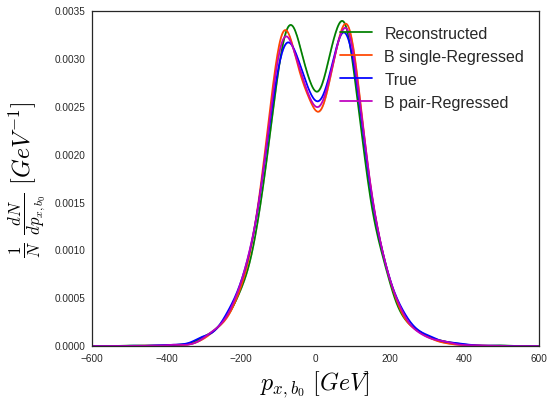

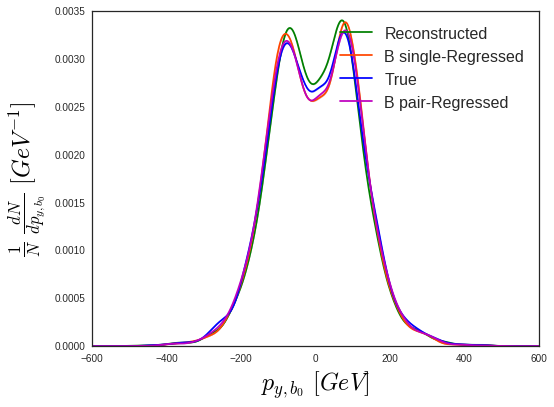

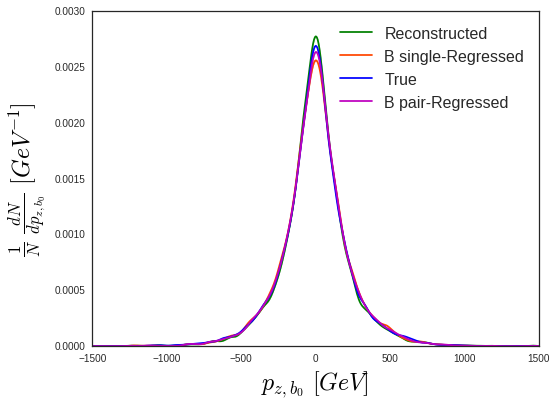

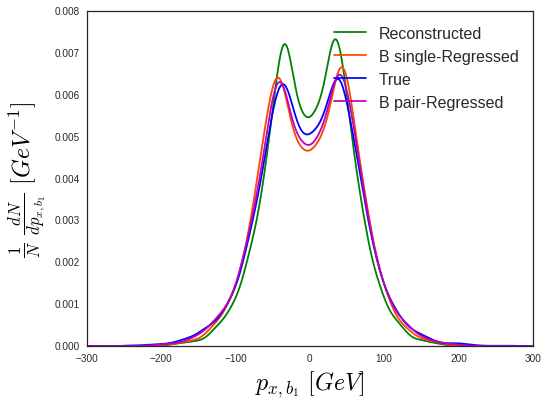

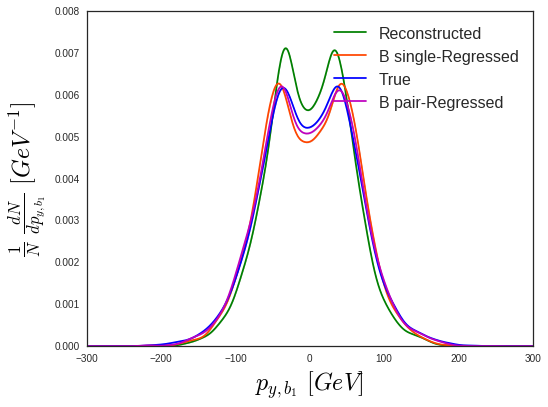

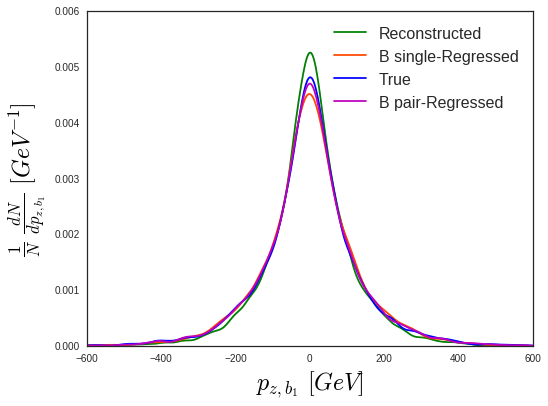

In [9]:
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot, condition='B single-Regressed', color='OrangeRed')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot, condition='B pair-Regressed', color='m')
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distributions

In [10]:
pltArgs = []
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

Reco:	px	0.0811781607108 +- 0.0242213720988	27.6817807248 +- 0.0965832281104
Reg Single:	px	-0.234228964291 +- 0.0161910297174	18.7744991166 +- 0.0457534869829
Reg Pair:	px	-0.195873526687 +- 0.012519772355	15.1338643511 +- 0.0311217971558
Reco:	py	-0.337026357396 +- 0.0244901477611	27.0656802641 +- 0.0785867531367
Reg Single:	py	-0.572966657405 +- 0.0180021406537	18.0564090831 +- 0.0410236177291
Reg Pair:	py	-0.269520589253 +- 0.0149895701028	14.5759906193 +- 0.0228422770329
Reco:	pz	-0.298677566309 +- 0.0537093238527	58.9087724873 +- 0.253923502639
Reg Single:	pz	0.399104510107 +- 0.0357053625308	37.1971156527 +- 0.169563182317
Reg Pair:	pz	1.59115653366 +- 0.0251284582748	28.5475544692 +- 0.090288201456
Reco:	px	0.0924035307582 +- 0.015684943347	18.0542224469 +- 0.0545569097961
Reg Single:	px	-0.336331668835 +- 0.013327706577	14.0340094237 +- 0.0274184027355
Reg Pair:	px	-0.178337162919 +- 0.0102456250936	10.2046999369 +- 0.0222115426062
Reco:	py	-0.0808794077869 +- 0.0159316236327	

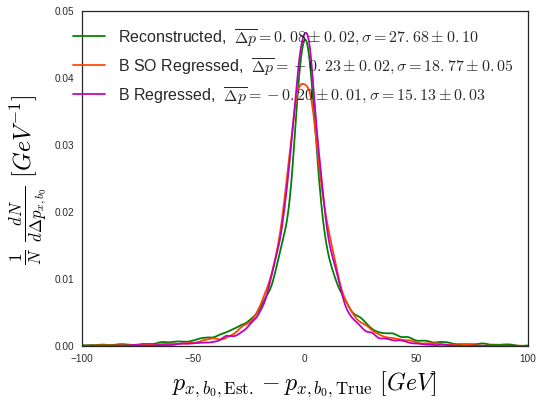

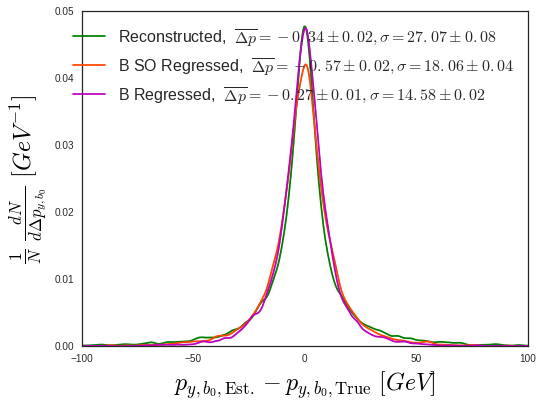

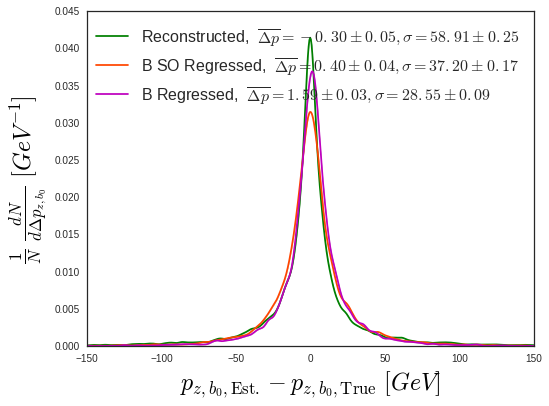

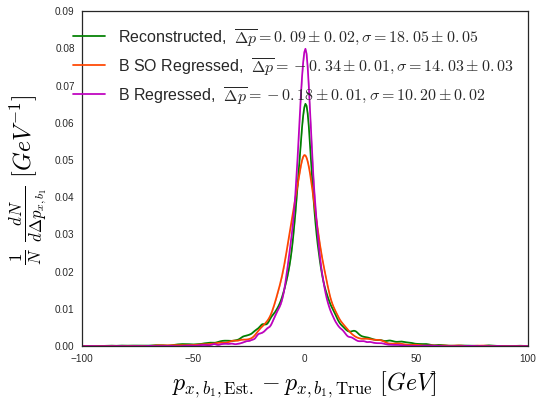

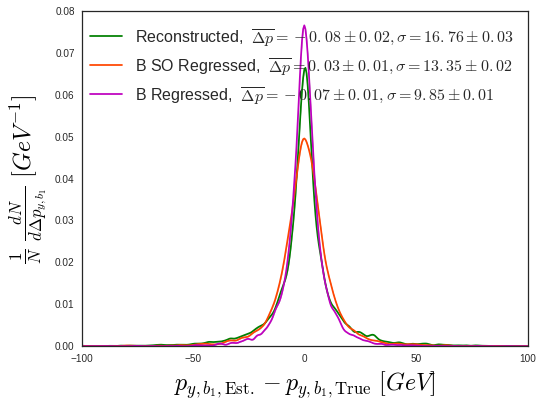

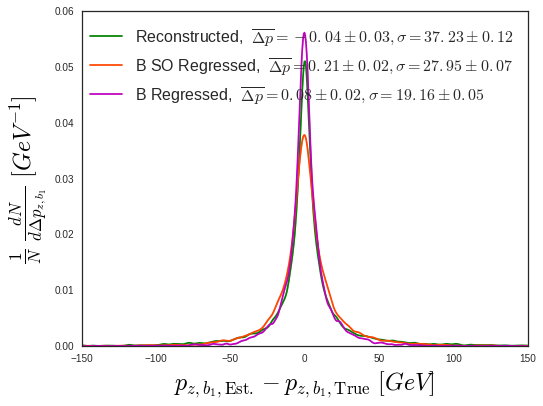

In [11]:
for n, feature in enumerate(bMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHBB_' + feature + '_mean']),
            np.std(plots['regHBB_' + feature + '_mean'])/math.sqrt(len(plots['regHBB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHBB_' + feature + '_std']),
             np.std(plots['regHBB_' + feature + '_std'])/math.sqrt(len(plots['regHBB_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot,
               condition=r'B SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='OrangeRed')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Two-sample Kolmogorov–Smirnov test

In [12]:
for n, feature in enumerate(bMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regB_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])


b_0_px
K-S test result 0.0064, p-value of 0.9608

b_0_py
K-S test result 0.0101, p-value of 0.5565

b_0_pz
K-S test result 0.0078, p-value of 0.8459

b_1_px
K-S test result 0.0144, p-value of 0.1547

b_1_py
K-S test result 0.0112, p-value of 0.4274

b_1_pz
K-S test result 0.0074, p-value of 0.8877


## Tau-quarks

In [13]:
tauMomFeats = ['t_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz']

### Momenta distributions

In [20]:
pltArgs = []
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHTT_" + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1}]
plots = mpRun(pltArgs)

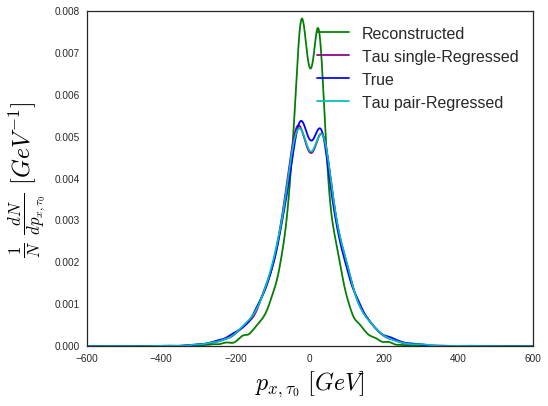

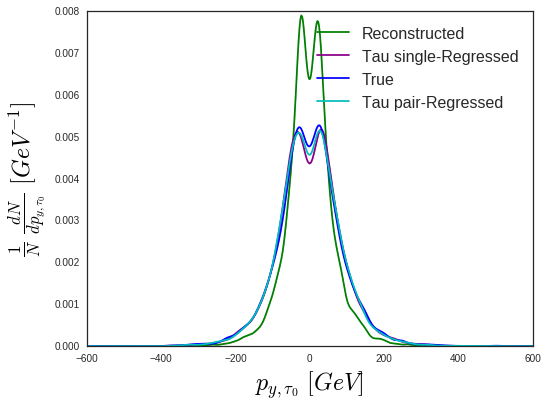

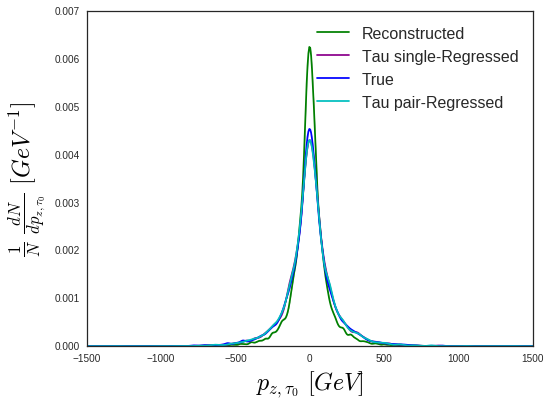

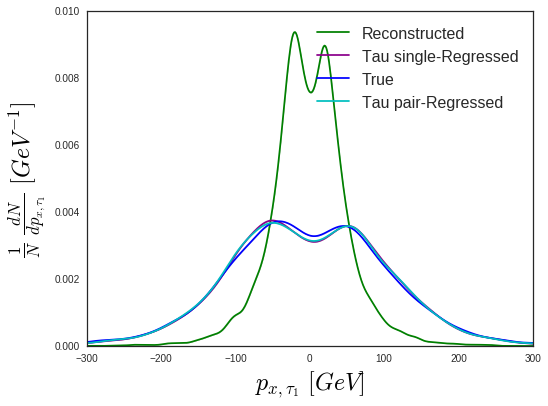

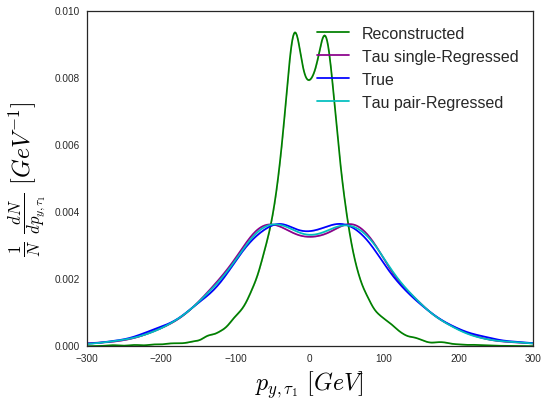

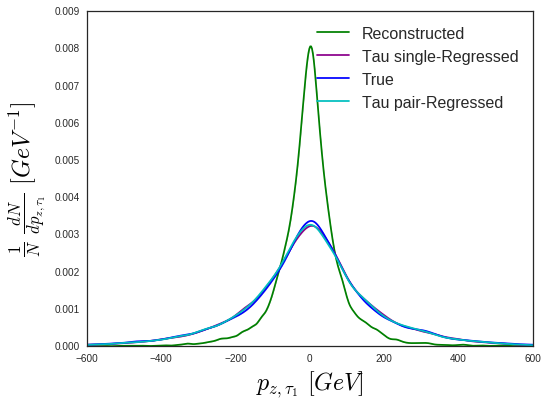

In [21]:
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot, condition='Tau single-Regressed', color='DarkMagenta')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    plt.legend(fontsize=16)
    var = r"p_{x,\tau_0}"
    if "py" in feature:
        var = r"p_{y,\tau_0}"
    if "pz" in feature:
        var = r"p_{z,\tau_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distributions

In [17]:
pltArgs = []
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

Reco:	px	0.575500692925 +- 0.0286005174682	35.4745470143 +- 0.0734287688877
Reg Single:	px	0.0712558845254 +- 0.0121735920827	14.021908559 +- 0.0234036963917
Reg Pair:	px	-0.120344131255 +- 0.011033016787	12.9645142335 +- 0.0257101315203
Reco:	py	0.0204234841201 +- 0.0298529493163	35.6627237489 +- 0.0615772093342
Reg Single:	py	-0.378533668729 +- 0.011765037101	13.8872593011 +- 0.0242964740113
Reg Pair:	py	-0.44806184726 +- 0.0107711192743	12.8461244332 +- 0.0208127972967
Reco:	pz	0.246149137654 +- 0.0570100772769	69.7468759661 +- 0.143315739573
Reg Single:	pz	0.212553993294 +- 0.0233028728899	27.6749425081 +- 0.0803129615268
Reg Pair:	pz	-0.71498911529 +- 0.0222064344392	25.830361023 +- 0.0814798465648
Reco:	px	0.960086766213 +- 0.0609728653737	65.6798300487 +- 0.0612909721444
Reg Single:	px	0.402010243876 +- 0.0149209791414	16.1223498638 +- 0.0249927260746
Reg Pair:	px	0.0984197241772 +- 0.0135591776788	14.915753122 +- 0.0199169930219
Reco:	py	0.535582164329 +- 0.0598039798656	64.009

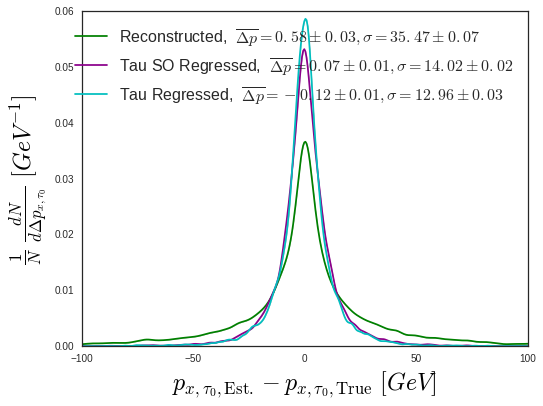

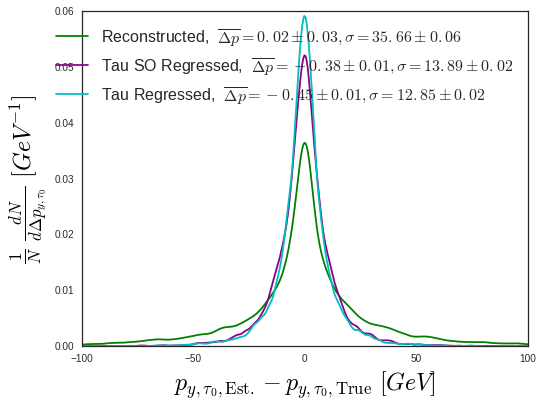

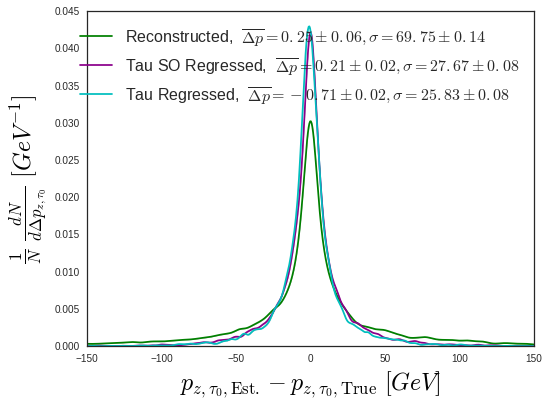

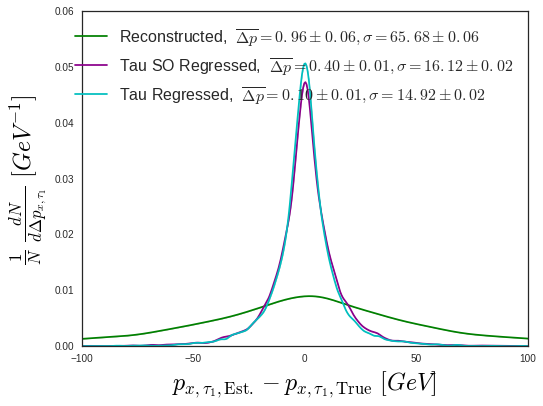

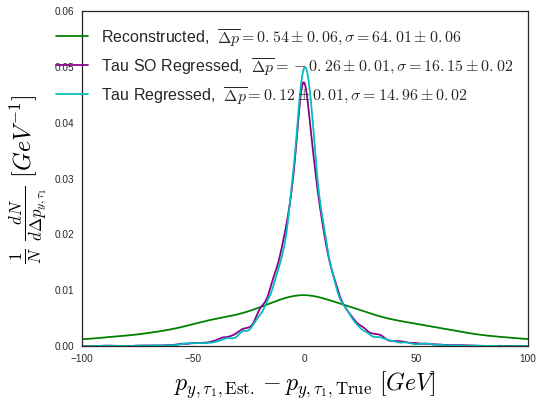

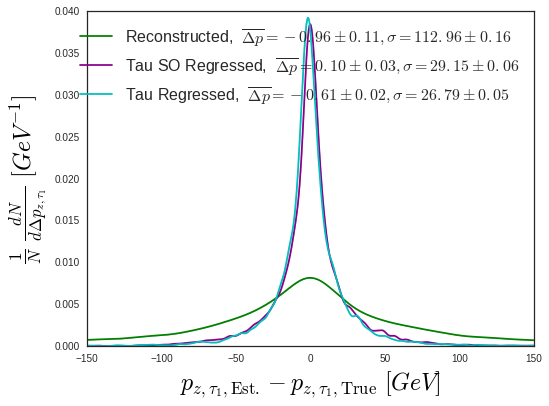

In [19]:
for n, feature in enumerate(tauMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,\tau_0"
    if "py" in feature:
        var = r"p_{y,\tau_0"
    if "pz" in feature:
        var = r"p_{z,\tau_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHTT_' + feature + '_mean']),
            np.std(plots['regHTT_' + feature + '_mean'])/math.sqrt(len(plots['regHTT_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHTT_' + feature + '_std']),
             np.std(plots['regHTT_' + feature + '_std'])/math.sqrt(len(plots['regHTT_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot,
               condition=r'Tau SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='DarkMagenta')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Two-sample Kolmogorov–Smirnov test

In [22]:
for n, feature in enumerate(tauMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regTau_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])


t_0_px
K-S test result 0.0120, p-value of 0.3407

t_0_py
K-S test result 0.0127, p-value of 0.2733

t_0_pz
K-S test result 0.0116, p-value of 0.3739

t_1_px
K-S test result 0.0105, p-value of 0.5050

t_1_py
K-S test result 0.0094, p-value of 0.6526

t_1_pz
K-S test result 0.0116, p-value of 0.3825


## Higgs-> bb

In [23]:
hbbMomFeats = ['h_bb_px', 'h_bb_py', 'h_bb_pz']

### Momenta distributions

In [24]:
pltArgs = []
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHBB_" + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1}]
plots = mpRun(pltArgs)

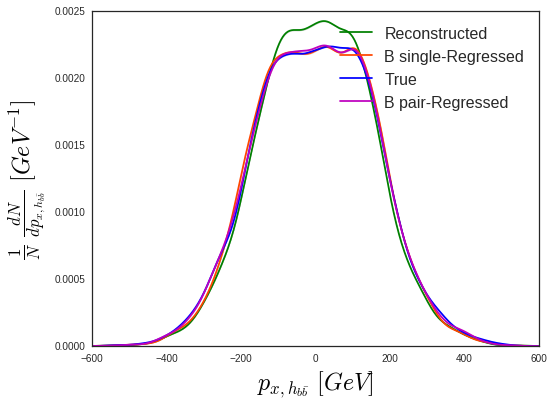

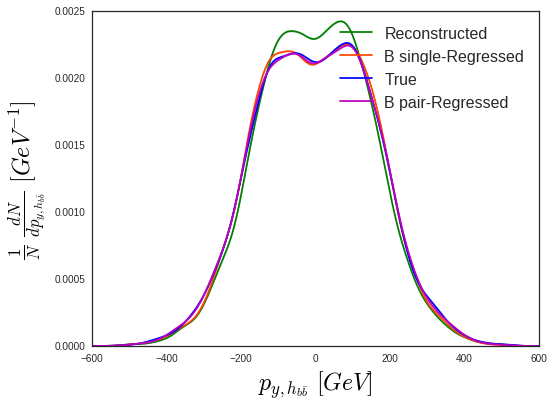

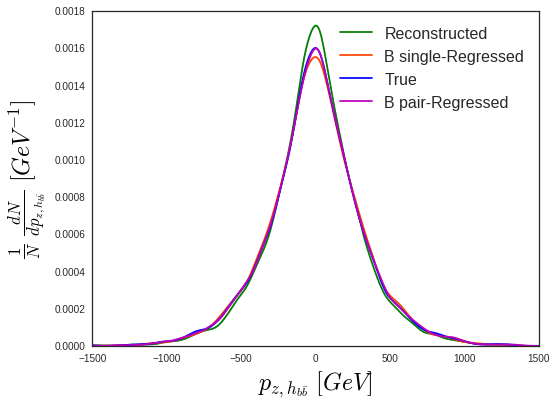

In [26]:
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot, condition='B single-Regressed', color='OrangeRed')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot, condition='B pair-Regressed', color='m')
    plt.legend(fontsize=16)
    var = r"p_{x,h_{b\bar{b}}}"
    if "py" in feature:
        var = r"p_{y,h_{b\bar{b}}}"
    if "pz" in feature:
        var = r"p_{z,h_{b\bar{b}}}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distributions

In [27]:
pltArgs = []
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHBB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHBB_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

Reco:	_px	0.173581666631 +- 0.0283988294207	31.9120371954 +- 0.0980155505007
Reg Single:	_px	-0.570560657966 +- 0.0187920773876	21.7826896003 +- 0.0485597448457
Reg Pair:	_px	-0.374210714445 +- 0.0143321747883	15.891545767 +- 0.0452543210394
Reco:	_py	-0.417905861587 +- 0.0274017766317	30.6710716327 +- 0.0736576894813
Reg Single:	_py	-0.541466816187 +- 0.020757904711	20.7353254043 +- 0.0440293760148
Reg Pair:	_py	-0.343627381519 +- 0.0135789160083	15.1109263262 +- 0.0228626638376
Reco:	_pz	-0.333828973176 +- 0.0653066028616	68.3806265563 +- 0.222244944681
Reg Single:	_pz	0.605569975412 +- 0.0427867408648	43.5198132821 +- 0.152400827437
Reg Pair:	_pz	1.66629009164 +- 0.0240490946156	27.6323929977 +- 0.0839298444887


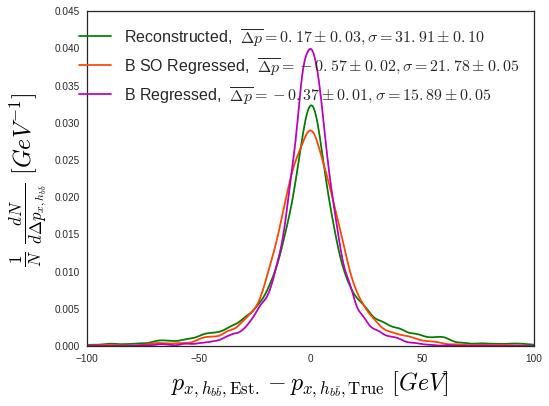

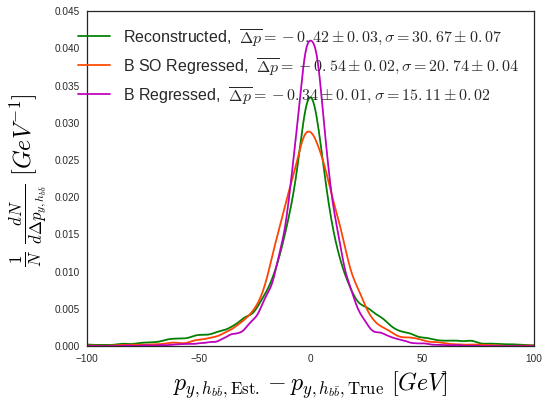

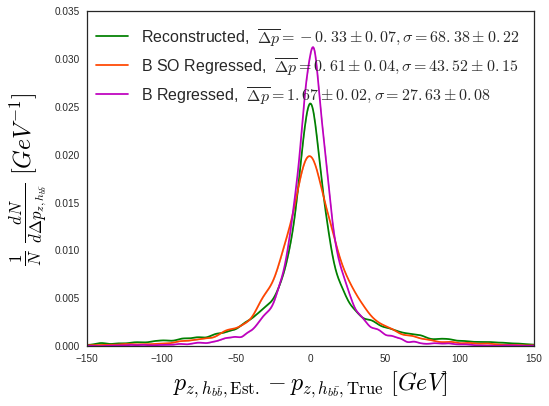

In [28]:
for n, feature in enumerate(hbbMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,h_{b\bar{b}}"
    if "py" in feature:
        var = r"p_{y,h_{b\bar{b}}"
    if "pz" in feature:
        var = r"p_{z,h_{b\bar{b}}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHBB_' + feature + '_mean']),
            np.std(plots['regHBB_' + feature + '_mean'])/math.sqrt(len(plots['regHBB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHBB_' + feature + '_std']),
             np.std(plots['regHBB_' + feature + '_std'])/math.sqrt(len(plots['regHBB_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHBB_' + feature + '_kde'], time=xPlot,
               condition=r'B SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='OrangeRed')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Two-sample Kolmogorov–Smirnov test

In [29]:
for n, feature in enumerate(hbbMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regB_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])


h_bb_px
K-S test result 0.0047, p-value of 0.9991

h_bb_py
K-S test result 0.0060, p-value of 0.9787

h_bb_pz
K-S test result 0.0050, p-value of 0.9981


### Mass

In [30]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'name':'regB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'h_bb_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'name':'regHBB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanRegB = (np.mean(plots['regB_mean']), np.std(plots['regB_mean'])/math.sqrt(len((plots['regB_mean']))))
stdRegB = (np.mean(plots['regB_std']), np.std(plots['regB_std'])/math.sqrt(len(plots['regB_std'])))
meanRegHBB = (np.mean(plots['regHBB_mean']), np.std(plots['regHBB_mean'])/math.sqrt(len((plots['regHBB_mean']))))
stdRegHBB = (np.mean(plots['regHBB_std']), np.std(plots['regHBB_std'])/math.sqrt(len(plots['regHBB_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'B Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1])
print 'B SO Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])

Distribution		mean	sigma
B Regressed Signal, Mean = 124.81400296 +- 0.00725209955015, sigma = 7.78099830581 +- 0.0311896238239
B SO Regressed Signal, Mean = 124.54998453 +- 0.0204090445775, sigma = 23.419844128 +- 0.0513930697581
Reconstructed Signal,  Mean = 118.598940488 +- 0.0265354647359, sigma = 32.8772037521 +- 0.107147006182


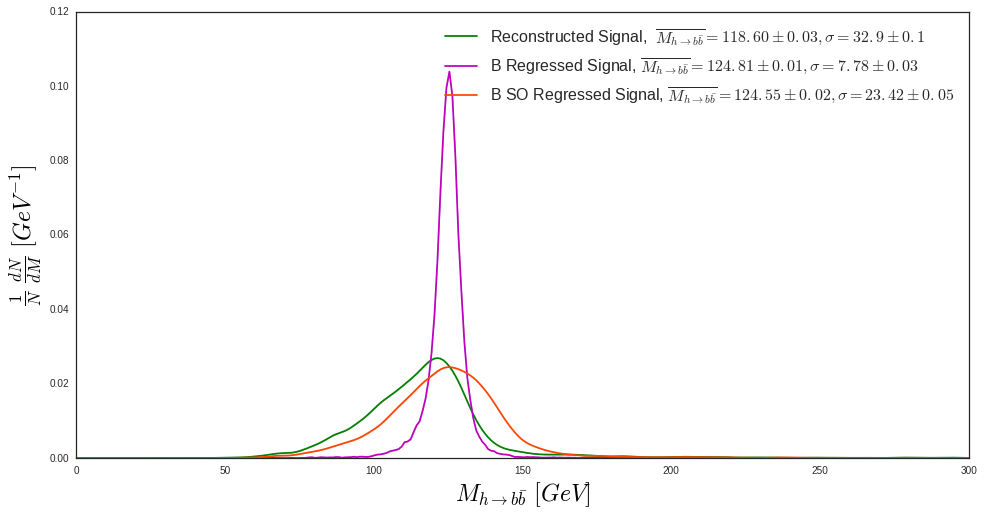

In [31]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['regB_kde'], time=xPlot, 
          condition=r'B Regressed Signal, $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]),
          color='m')
sns.tsplot(data=plots['regHBB_kde'], time=xPlot, 
          condition=r'B SO Regressed Signal, $\overline{M_{h\rightarrow b\bar{b}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegHBB[0], meanRegHBB[1], stdRegHBB[0], stdRegHBB[1]),
          color='OrangeRed')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [32]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkgVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regB', 'kde':1},
               {'data':valData.ix[sigVal, 'regB_h_bb_mass'], 'x':xPlot, 'name':'sig_regB', 'kde':1},
               {'data':valData.ix[bkgVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'bkg_regHBB', 'kde':1},
               {'data':valData.ix[sigVal, 'regHBB_h_bb_mass'], 'x':xPlot, 'name':'sig_regHBB', 'kde':1}])

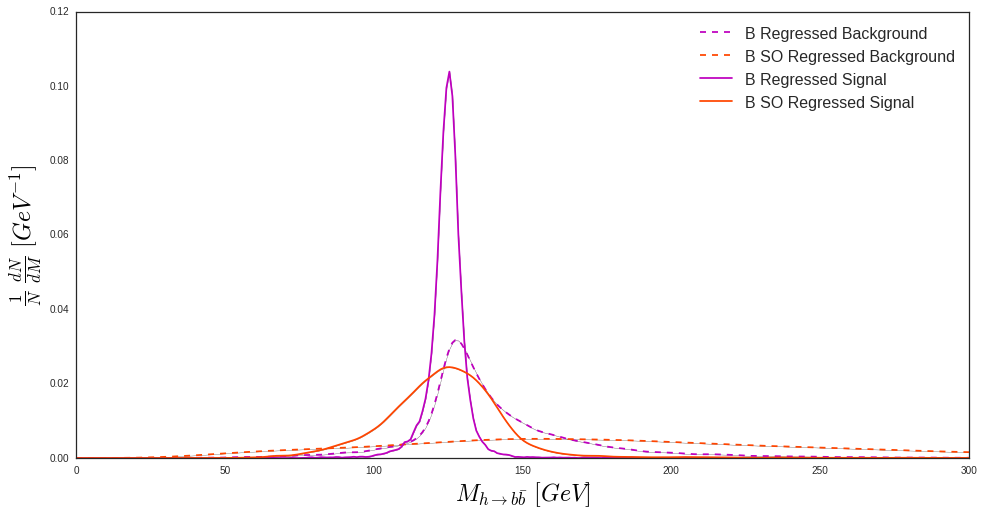

In [33]:
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['bkg_regB' + '_kde'], time=xPlot, ci=[68, 95], color='m', linestyle="dashed", condition="B Regressed Background")
sns.tsplot(data=plots['bkg_regHBB' + '_kde'], time=xPlot, ci=[68, 95], color='OrangeRed', linestyle="dashed", condition="B SO Regressed Background")
sns.tsplot(data=plots['sig_regB' + '_kde'], time=xPlot, ci=[68, 95], color='m', condition="B Regressed Signal")
sns.tsplot(data=plots['sig_regHBB' + '_kde'], time=xPlot, ci=[68, 95], color='OrangeRed', condition="B SO Regressed Signal")
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

## Higgs-> TauTau

In [34]:
httMomFeats = ['h_tt_px', 'h_tt_py', 'h_tt_pz']

### Momenta distributions

In [35]:
pltArgs = []
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHTT_" + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1}]
plots = mpRun(pltArgs)

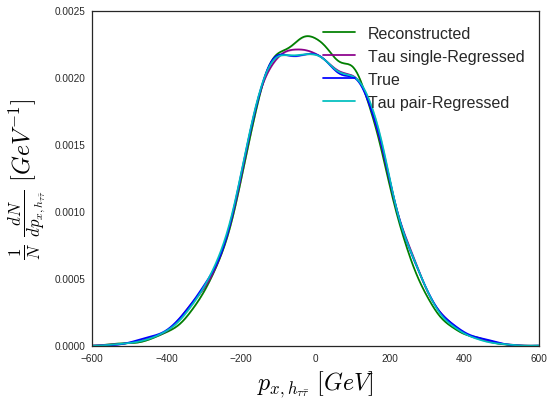

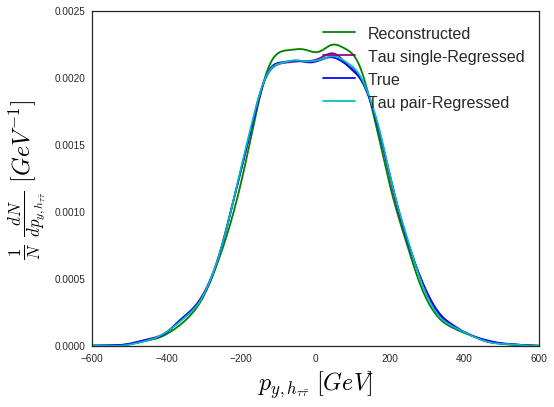

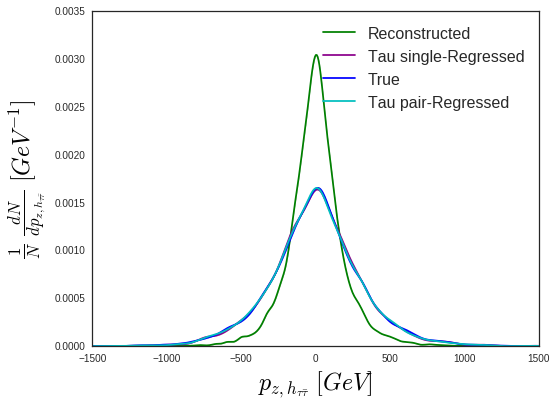

In [37]:
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot, condition='Tau single-Regressed', color='DarkMagenta')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    plt.legend(fontsize=16)
    var = r"p_{x,h_{\tau\bar{\tau}}}"
    if "py" in feature:
        var = r"p_{y,h_{\tau\bar{\tau}}}"
    if "pz" in feature:
        var = r"p_{z,h_{\tau\bar{\tau}}}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distributions

In [38]:
pltArgs = []
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regHTT_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHTT_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

Reco:	_px	0.236650950141 +- 0.0245874940673	28.2708853976 +- 0.0635059277032
Reg Single:	_px	0.473266094765 +- 0.0142284292788	17.4538078447 +- 0.0190761160301
Reg Pair:	_px	-0.0219244407157 +- 0.0124584753398	15.6629998939 +- 0.0179435316462
Reco:	_py	0.259513047211 +- 0.0252215381328	27.5538134323 +- 0.0568236155195
Reg Single:	_py	-0.634026512049 +- 0.0155899212468	17.4320450268 +- 0.02530444928
Reg Pair:	_py	-0.323066206603 +- 0.0141282865085	15.5156817812 +- 0.0208367848368
Reco:	_pz	-0.716631814155 +- 0.134762282005	150.102792758 +- 0.178355862485
Reg Single:	_pz	0.308252937909 +- 0.0319356119614	36.0928427142 +- 0.0568713257888
Reg Pair:	_pz	-1.32199029505 +- 0.0280919607155	30.6614638798 +- 0.0551598941572


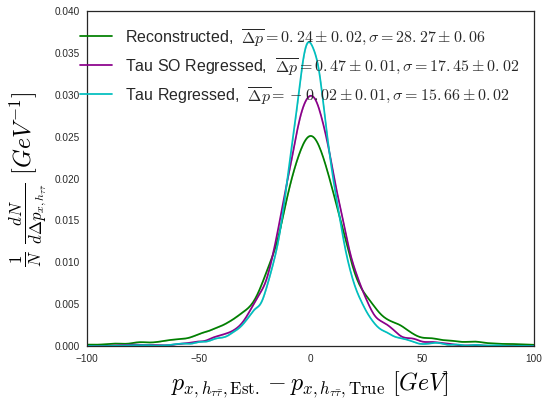

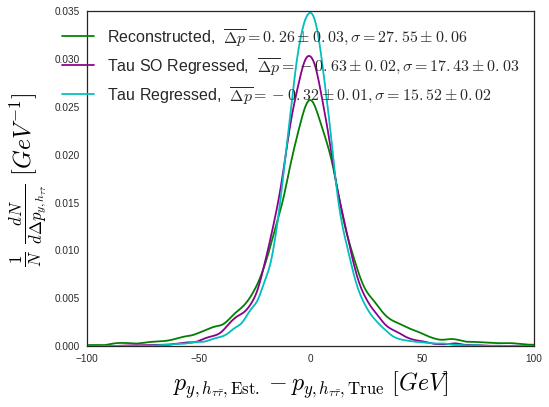

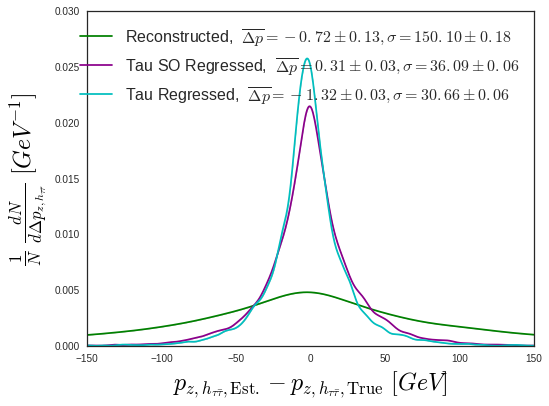

In [39]:
for n, feature in enumerate(httMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,h_{\tau\bar{\tau}}"
    if "py" in feature:
        var = r"p_{y,h_{\tau\bar{\tau}}"
    if "pz" in feature:
        var = r"p_{z,h_{\tau\bar{\tau}}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regHTT_' + feature + '_mean']),
            np.std(plots['regHTT_' + feature + '_mean'])/math.sqrt(len(plots['regHTT_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHTT_' + feature + '_std']),
             np.std(plots['regHTT_' + feature + '_std'])/math.sqrt(len(plots['regHTT_' + feature + '_std'])))
    print "Reg Single:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHTT_' + feature + '_kde'], time=xPlot,
               condition=r'Tau SO Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='DarkMagenta')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Two-sample Kolmogorov–Smirnov test

In [40]:
for n, feature in enumerate(httMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regTau_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])


h_tt_px
K-S test result 0.0042, p-value of 0.9999

h_tt_py
K-S test result 0.0050, p-value of 0.9976

h_tt_pz
K-S test result 0.0068, p-value of 0.9354


### Mass

In [41]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'name':'regTau', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'h_tt_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'name':'regHTT', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanRegTau = (np.mean(plots['regTau_mean']), np.std(plots['regTau_mean'])/math.sqrt(len((plots['regTau_mean']))))
stdRegTau = (np.mean(plots['regTau_std']), np.std(plots['regTau_std'])/math.sqrt(len(plots['regTau_std'])))
meanRegHTT = (np.mean(plots['regHTT_mean']), np.std(plots['regHTT_mean'])/math.sqrt(len((plots['regHTT_mean']))))
stdRegHTT = (np.mean(plots['regHTT_std']), np.std(plots['regHTT_std'])/math.sqrt(len(plots['regHTT_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'Tau Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1])
print 'Tau SO Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])

Distribution		mean	sigma
Tau Regressed Signal, Mean = 124.925840462 +- 0.0102436446471, sigma = 11.633827286 +- 0.0191491988167
Tau SO Regressed Signal, Mean = 126.82223876 +- 0.0137801871683, sigma = 17.1829843514 +- 0.0319820693374
Reconstructed Signal,  Mean = 144.748791319 +- 0.0518337015742, sigma = 57.283617227 +- 0.0931767243281


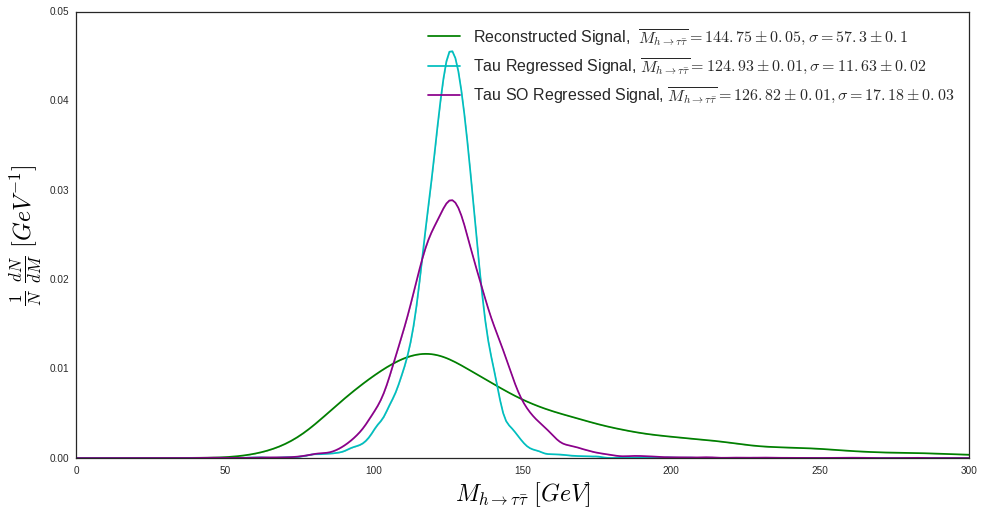

In [42]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['regTau_kde'], time=xPlot, 
          condition=r'Tau Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]),
          color='c')
sns.tsplot(data=plots['regHTT_kde'], time=xPlot, 
          condition=r'Tau SO Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanRegHTT[0], meanRegHTT[1], stdRegHTT[0], stdRegHTT[1]),
          color='DarkMagenta')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [43]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkgVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'bkg_regTau', 'kde':1},
               {'data':valData.ix[sigVal, 'regTau_h_tt_mass'], 'x':xPlot, 'name':'sig_regTau', 'kde':1},
               {'data':valData.ix[bkgVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'bkg_regHTT', 'kde':1},
               {'data':valData.ix[sigVal, 'regHTT_h_tt_mass'], 'x':xPlot, 'name':'sig_regHTT', 'kde':1}])

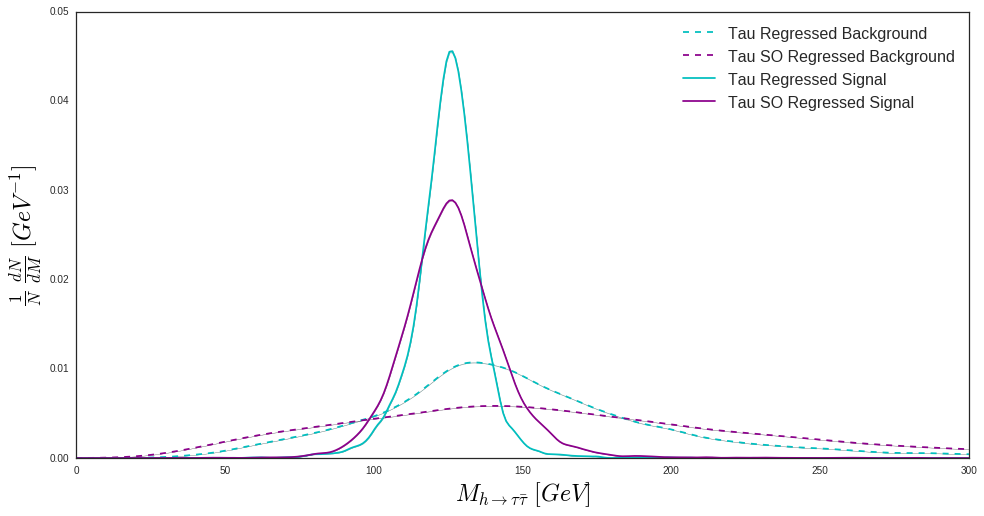

In [44]:
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['bkg_regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c', linestyle="dashed", condition="Tau Regressed Background")
sns.tsplot(data=plots['bkg_regHTT' + '_kde'], time=xPlot, ci=[68, 95], color='DarkMagenta', linestyle="dashed", condition="Tau SO Regressed Background")
sns.tsplot(data=plots['sig_regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c', condition="Tau Regressed Signal")
sns.tsplot(data=plots['sig_regHTT' + '_kde'], time=xPlot, ci=[68, 95], color='DarkMagenta', condition="Tau SO Regressed Signal")
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

## Di-Higgs

In [45]:
hhMomFeats = ['diH_px', 'diH_py', 'diH_pz']

### Momenta distributions

In [47]:
pltArgs = []
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, "gen_" + feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regTau_" + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regB_" + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1},
                {'data':valData.ix[sigVal, "regHH_" + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1}]
plots = mpRun(pltArgs)

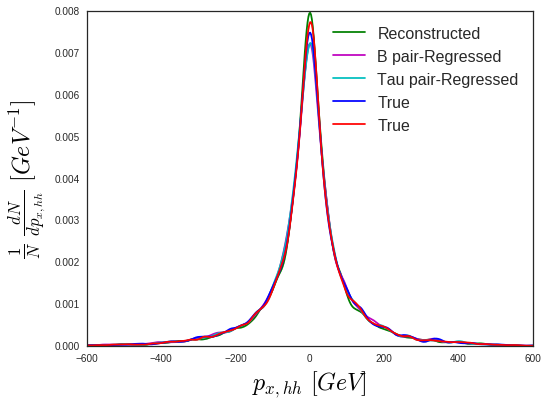

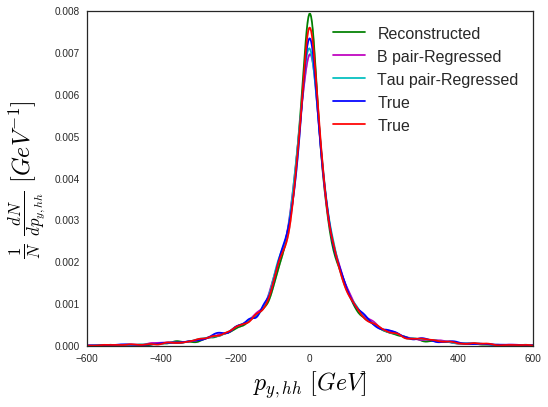

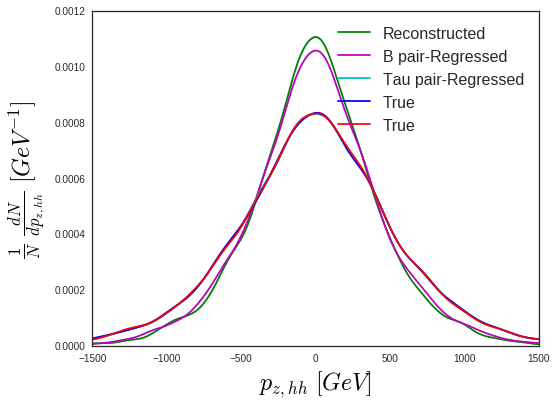

In [48]:
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot, condition='B pair-Regressed', color='m')
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot, condition='Tau pair-Regressed', color='c')
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['regHH_' + feature + '_kde'], time=xPlot, condition='True', color='r')
    plt.legend(fontsize=16)
    var = r"p_{x,hh}"
    if "py" in feature:
        var = r"p_{y,hh}"
    if "pz" in feature:
        var = r"p_{z,hh}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distributions

In [50]:
pltArgs = []
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sigVal, feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regTau_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regTau_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regB_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regB_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sigVal, 'regHH_' + feature]-valData.ix[sigVal, 'gen_' + feature], 'x':xPlot, 'name':'regHH_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

Reco:	px	0.410232616777 +- 0.0270674843949	31.8049159538 +- 0.0976608915796
B Reg Pair:	px	-0.137559764299 +- 0.0253204316825	27.7195968656 +- 0.0700409111487
Tau Reg Pair:	px	-0.396135155157 +- 0.0164715921164	17.7106666351 +- 0.0396905904558
HH Reg Pair:	px	0.533712939999 +- 0.014485406632	16.1309040196 +- 0.0429831505961
Reco:	py	-0.158392814373 +- 0.025170153194	30.6994888246 +- 0.0927542634719
B Reg Pair:	py	-0.0841143343021 +- 0.0241544131609	26.9684537812 +- 0.0545089495039
Tau Reg Pair:	py	-0.666693588117 +- 0.0144933324045	17.3063342601 +- 0.0251250817125
HH Reg Pair:	py	0.227211271042 +- 0.0136885969888	15.9861449624 +- 0.0252310699318
Reco:	pz	-1.05046078736 +- 0.158534739321	172.442088395 +- 0.185694524128
B Reg Pair:	pz	0.949658277445 +- 0.138593080402	153.568546904 +- 0.179935032319
Tau Reg Pair:	pz	0.34429979655 +- 0.0402156221822	42.8606660036 +- 0.0749018930901
HH Reg Pair:	pz	-1.05970401352 +- 0.0382164664819	39.6963051087 +- 0.074732739374


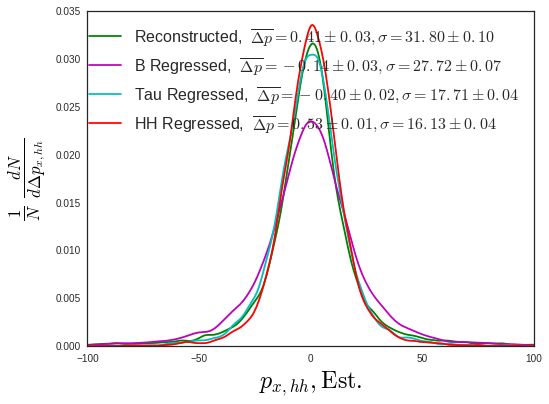

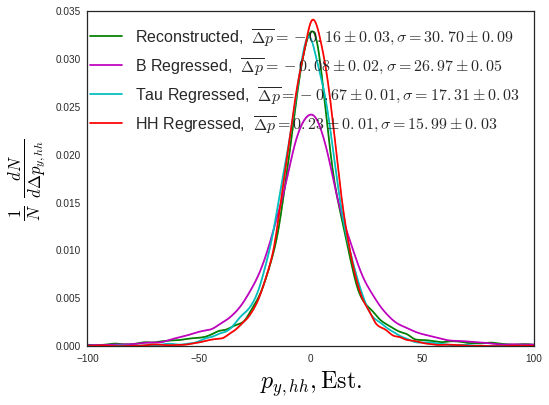

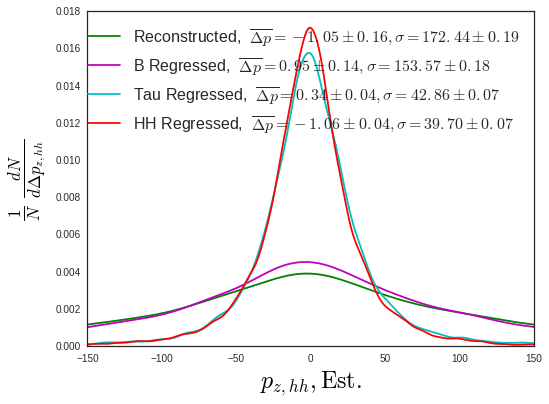

In [52]:
for n, feature in enumerate(hhMomFeats):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = r"p_{x,hh}"
    if "py" in feature:
        var = r"p_{y,hh}"
    if "pz" in feature:
        var = r"p_{z,hh}"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['regB_' + feature + '_mean']),
            np.std(plots['regB_' + feature + '_mean'])/math.sqrt(len(plots['regB_' + feature + '_mean'])))
    stdev = (np.mean(plots['regB_' + feature + '_std']),
             np.std(plots['regB_' + feature + '_std'])/math.sqrt(len(plots['regB_' + feature + '_std'])))
    print "B Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regB_' + feature + '_kde'], time=xPlot,
               condition=r'B Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='m')
    mean = (np.mean(plots['regTau_' + feature + '_mean']),
            np.std(plots['regTau_' + feature + '_mean'])/math.sqrt(len(plots['regTau_' + feature + '_mean'])))
    stdev = (np.mean(plots['regTau_' + feature + '_std']),
             np.std(plots['regTau_' + feature + '_std'])/math.sqrt(len(plots['regTau_' + feature + '_std'])))
    print "Tau Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regTau_' + feature + '_kde'], time=xPlot,
               condition=r'Tau Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    mean = (np.mean(plots['regHH_' + feature + '_mean']),
            np.std(plots['regHH_' + feature + '_mean'])/math.sqrt(len(plots['regHH_' + feature + '_mean'])))
    stdev = (np.mean(plots['regHH_' + feature + '_std']),
             np.std(plots['regHH_' + feature + '_std'])/math.sqrt(len(plots['regHH_' + feature + '_std'])))
    print "HH Reg Pair:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['regHH_' + feature + '_kde'], time=xPlot,
               condition=r'HH Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='r')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Two-sample Kolmogorov–Smirnov test

In [53]:
for n, feature in enumerate(hhMomFeats):
    print 
    print feature
    ksTest = ks_2samp(valData[sigVal]['gen_' + feature].values, valData[sigVal]['regHH_' + feature].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])


diH_px
K-S test result 0.0098, p-value of 0.5989

diH_py
K-S test result 0.0107, p-value of 0.4752

diH_pz
K-S test result 0.0041, p-value of 1.0000


### Mass

In [67]:
xPlot = np.linspace(150, 1200, 1050)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'gen_diH_mass'], 'name':'gen', 'x':xPlot, 'kde':1},
               {'data':valData.ix[sigVal, 'regTau_diH_mass'], 'name':'regTau', 'x':xPlot, 'kde':1},
               {'data':valData.ix[sigVal, 'diH_mass'], 'name':'rec', 'x':xPlot, 'kde':1},
               {'data':valData.ix[sigVal, 'regB_diH_mass'], 'name':'regB', 'x':xPlot, 'kde':1},
               {'data':valData.ix[sigVal, 'regHH_diH_mass'], 'name':'regHH', 'x':xPlot, 'kde':1}])

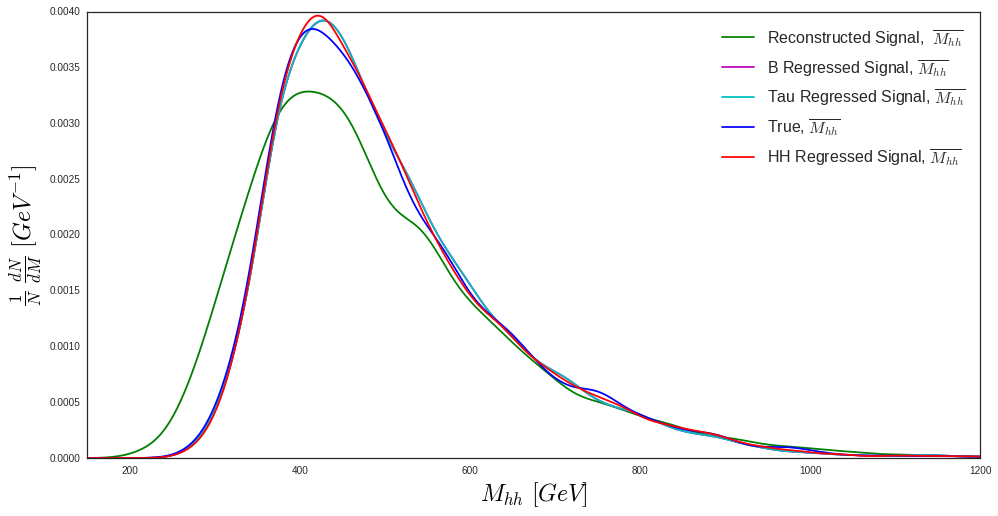

In [68]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{hh}}$',
          color='g')
sns.tsplot(data=plots['regTau_kde'], time=xPlot, 
          condition=r'B Regressed Signal, $\overline{M_{hh}}$',
          color='m')
sns.tsplot(data=plots['regTau_kde'], time=xPlot, 
          condition=r'Tau Regressed Signal, $\overline{M_{hh}}$',
          color='c')
sns.tsplot(data=plots['gen_kde'], time=xPlot, 
          condition=r'True, $\overline{M_{hh}}$',
          color='b')
sns.tsplot(data=plots['regHH_kde'], time=xPlot, 
          condition=r'HH Regressed Signal, $\overline{M_{hh}}$',
          color='r')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [69]:
xPlot = np.linspace(150, 1200, 1050)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkgVal, 'regHH_diH_mass'], 'x':xPlot, 'name':'bkg_regHH', 'kde':1},
               {'data':valData.ix[bkgVal, 'diH_mass'], 'x':xPlot, 'name':'bkg_rec', 'kde':1},
               {'data':valData.ix[sigVal, 'diH_mass'], 'x':xPlot, 'name':'sig_rec', 'kde':1},
               {'data':valData.ix[sigVal, 'regHH_diH_mass'], 'x':xPlot, 'name':'sig_regHH', 'kde':1}])

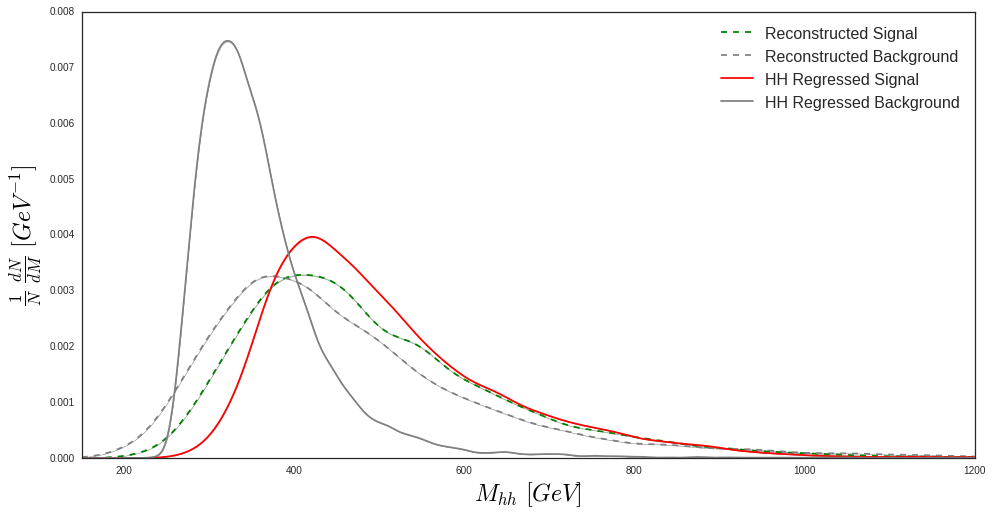

In [70]:
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['sig_rec' + '_kde'], time=xPlot, ci=[68, 95], color='g', linestyle="dashed", condition="Reconstructed Signal")
sns.tsplot(data=plots['bkg_rec' + '_kde'], time=xPlot, ci=[68, 95], color='grey', linestyle="dashed", condition="Reconstructed Background")
sns.tsplot(data=plots['sig_regHH' + '_kde'], time=xPlot, ci=[68, 95], color='r', condition="HH Regressed Signal")
sns.tsplot(data=plots['bkg_regHH' + '_kde'], time=xPlot, ci=[68, 95], color='grey', condition="HH Regressed Background")
plt.legend(fontsize=16)
plt.xlabel(r'$M_{hh}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Delta distribution

In [7]:
xPlot = np.linspace(-500, 500, 1000)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sigVal, 'regTau_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regTau', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regB_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regB', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sigVal, 'regHH_diH_mass']-valData.ix[sigVal, 'gen_diH_mass'], 'name':'regHH', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanRegHH = (np.mean(plots['regHH' + '_mean']), np.std(plots['regHH' + '_mean'])/math.sqrt(len(plots['regHH' + '_mean'])))
stdRegHH = (np.mean(plots['regHH' + '_std']), np.std(plots['regHH' + '_std'])/math.sqrt(len(plots['regHH' + '_std'])))
print 'HH Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHH[0], meanRegHH[1], stdRegHH[0], stdRegHH[1])
meanRegTau = (np.mean(plots['regTau' + '_mean']), np.std(plots['regTau' + '_mean'])/math.sqrt(len(plots['regTau' + '_mean'])))
stdRegTau = (np.mean(plots['regTau' + '_std']), np.std(plots['regTau' + '_std'])/math.sqrt(len(plots['regTau' + '_std'])))
print 'Tau Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1])
meanRegB = (np.mean(plots['regB' + '_mean']), np.std(plots['regB' + '_mean'])/math.sqrt(len(plots['regB' + '_mean'])))
stdRegB = (np.mean(plots['regB' + '_std']), np.std(plots['regB' + '_std'])/math.sqrt(len(plots['regB' + '_std'])))
print 'B Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1])
meanRec = (np.mean(plots['rec' + '_mean']), np.std(plots['rec' + '_mean'])/math.sqrt(len(plots['rec' + '_mean'])))
stdRec = (np.mean(plots['rec' + '_std']), np.std(plots['rec' + '_std'])/math.sqrt(len(plots['rec' + '_std'])))
print 'Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanRec[0], meanRec[1], stdRec[0], stdRec[1])

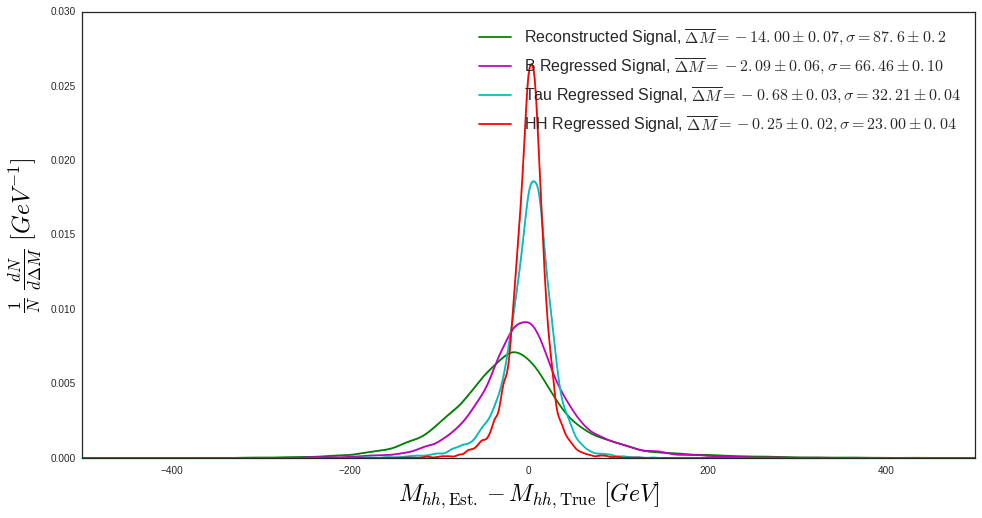

In [13]:
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec' + '_kde'], time=xPlot, ci=[68, 95], color='g',
           condition="Reconstructed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$".format(meanRec[0], meanRec[1], stdRec[0], stdRec[1]))
sns.tsplot(data=plots['regB' + '_kde'], time=xPlot, ci=[68, 95], color='m',
           condition="B Regressed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$".format(meanRegB[0], meanRegB[1], stdRegB[0], stdRegB[1]))
sns.tsplot(data=plots['regTau' + '_kde'], time=xPlot, ci=[68, 95], color='c',
           condition="Tau Regressed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$".format(meanRegTau[0], meanRegTau[1], stdRegTau[0], stdRegTau[1]))
sns.tsplot(data=plots['regHH' + '_kde'], time=xPlot, ci=[68, 95], color='r',
           condition="HH Regressed Signal, $\overline{\Delta M}" + r" = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$".format(meanRegHH[0], meanRegHH[1], stdRegHH[0], stdRegHH[1]))
plt.legend(fontsize=16)
plt.xlabel(r"$M_{hh,\mathrm{Est.}}-M_{hh,\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.yticks
plt.show()

## Classifier response

### Train

In [14]:
classFeatures = ['b_0_mass',
                 'b_1_mass',
                 't_0_mass',
                 't_1_mass',
                 'mPT_px', 'mPT_py',
                 'hl_mT']

In [21]:
recoFeatures = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
                'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
                't_0_px', 't_0_py', 't_0_pz', 't_0_E', 't_0_|p|',
                't_1_px', 't_1_py', 't_1_pz', 't_1_E', 't_1_|p|',
                'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_mass', 'h_bb_|p|', 'h_bb_E',
                'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_mass', 'h_tt_E', 'h_tt_|p|',
                'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|']
recoFeatures += classFeatures
print len(recoFeatures), "Training features"
recoClass = XGBoostClassifier()
recoClass.fit(devData[recoFeatures], devData['gen_target'].values.astype('int'))

45 Training features


XGBoostClassifier(base_score=0.5, colsample=1.0, eta=0.3,
         features=['b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 't_0_px', 't_0_py', 't_0_pz', 't_0_E', 't_0_|p|', 't_1_px', 't_1_py', 't_1_pz', 't_1_E', 't_1_|p|', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_mass', 'h_bb_|p|', 'h_bb_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_mass', 'h_tt_E', 'h_tt_|p|', 'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|', 'b_0_mass', 'b_1_mass', 't_0_mass', 't_1_mass', 'mPT_px', 'mPT_py', 'hl_mT'],
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=16, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=1.0, verbose=0)

In [22]:
regFeatures = ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
               'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
               'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
               'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
               'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regHBB_h_bb_mass', 'regB_h_bb_|p|', 'regB_h_bb_E',
               'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regHTT_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
               'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_mass', 'regHH_diH_E', 'regHH_diH_|p|']
regFeatures += classFeatures
print len(regFeatures), "Training features"
regClass = XGBoostClassifier()
regClass.fit(devData[regFeatures], devData['gen_target'].values.astype('int'))

45 Training features


XGBoostClassifier(base_score=0.5, colsample=1.0, eta=0.3,
         features=['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'reg...iH_E', 'regHH_diH_|p|', 'b_0_mass', 'b_1_mass', 't_0_mass', 't_1_mass', 'mPT_px', 'mPT_py', 'hl_mT'],
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=16, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=1.0, verbose=0)

### Test

In [23]:
recoPred = [recoClass.predict_proba(devData[recoFeatures])[:,1],
            recoClass.predict_proba(valData[recoFeatures])[:,1]]

In [24]:
regPred = [regClass.predict_proba(devData[regFeatures])[:,1],
           regClass.predict_proba(valData[regFeatures])[:,1]]

In [25]:
recoAUC = [roc_auc_score(devData['gen_target'].values, recoPred[0]),
           roc_auc_score(valData['gen_target'].values, recoPred[1])]
regAUC = [roc_auc_score(devData['gen_target'].values, regPred[0]),
          roc_auc_score(valData['gen_target'].values, regPred[1])]

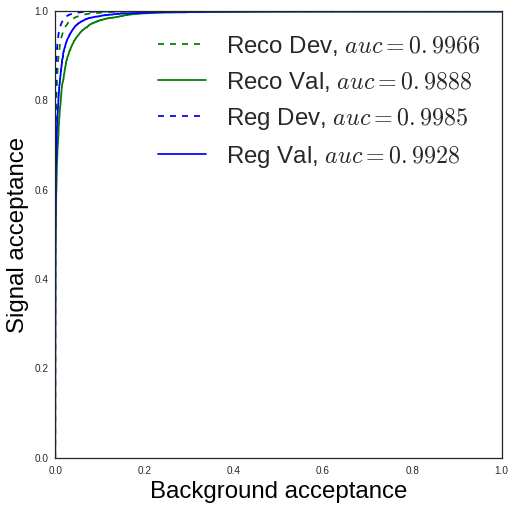

In [26]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devData['gen_target'].values, recoPred[0])[:2],
         label=r'Reco Dev, $auc={:.4f}$'.format(recoAUC[0]), linestyle='dashed', color='g')
plt.plot(*roc_curve(valData['gen_target'].values, recoPred[1])[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC[1]), color='g')
plt.plot(*roc_curve(devData['gen_target'].values, regPred[0])[:2],
         label=r'Reg Dev, $auc={:.4f}$'.format(regAUC[0]), linestyle='dashed', color='b')
plt.plot(*roc_curve(valData['gen_target'].values, regPred[1])[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC[1]), color='b')
#plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()

# Save selected data

In [5]:
regFeatures = ['regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_0_|p|', 'regB_b_0_E',
               'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_1_|p|', 'regB_b_1_E',
               'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_0_E', 'regTau_t_0_|p|',
               'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_1_E', 'regTau_t_1_|p|',
               'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regHBB_h_bb_mass', 'regB_h_bb_|p|', 'regB_h_bb_E',
               'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regHTT_h_tt_mass', 'regTau_h_tt_E', 'regTau_h_tt_|p|',
               'regHH_diH_px', 'regHH_diH_py', 'regHH_diH_pz', 'regHH_diH_mass', 'regHH_diH_E', 'regHH_diH_|p|']

In [6]:
cutData = data.copy()

In [7]:
len(cutData.columns), [x for x in cutData.columns]

(309,
 ['Unnamed: 0',
  'aplanarityA',
  'aplanarityP',
  'aplanorityA',
  'aplanorityP',
  'b_0_eta',
  'b_0_mass',
  'b_0_pT',
  'b_0_phi',
  'b_1_eta',
  'b_1_mass',
  'b_1_pT',
  'b_1_phi',
  'centrality',
  'dShapeA',
  'dShapeP',
  'diH_eta',
  'diH_mass',
  'diH_pT',
  'diH_phi',
  'eVis',
  'gen_b_0_E',
  'gen_b_0_E.1',
  'gen_b_0_eta',
  'gen_b_0_pT',
  'gen_b_0_phi',
  'gen_b_1_E',
  'gen_b_1_E.1',
  'gen_b_1_eta',
  'gen_b_1_pT',
  'gen_b_1_phi',
  'gen_h_bb_E',
  'gen_h_bb_E.1',
  'gen_h_bb_eta',
  'gen_h_bb_pT',
  'gen_h_bb_phi',
  'gen_h_tt_E',
  'gen_h_tt_E.1',
  'gen_h_tt_eta',
  'gen_h_tt_pT',
  'gen_h_tt_phi',
  'gen_diH_E',
  'gen_diH_E.1',
  'gen_diH_eta',
  'gen_diH_pT',
  'gen_diH_phi',
  'gen_diH_mass',
  'gen_mctMatch',
  'gen_t_0_E',
  'gen_t_0_E.1',
  'gen_t_0_eta',
  'gen_t_0_pT',
  'gen_t_0_phi',
  'gen_t_1_E',
  'gen_t_1_E.1',
  'gen_t_1_eta',
  'gen_t_1_pT',
  'gen_t_1_phi',
  'gen_target',
  'gen_weight',
  'hT',
  'h_bb_eta',
  'h_bb_mass',
  'h_bb_pT',


In [8]:
cutFeats = [x for x in cutData.columns if '.1' in x]
print len(cutFeats), cutFeats

8 ['gen_b_0_E.1', 'gen_b_1_E.1', 'gen_h_bb_E.1', 'gen_h_tt_E.1', 'gen_diH_E.1', 'gen_t_0_E.1', 'gen_t_1_E.1', 'gen_weight.1']


In [9]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [10]:
cutFeats = [x for x in cutData.columns if 'phi' in x or 'eta' in x or 'pT' in x]
print len(cutFeats), cutFeats

44 ['b_0_eta', 'b_0_pT', 'b_0_phi', 'b_1_eta', 'b_1_pT', 'b_1_phi', 'diH_eta', 'diH_pT', 'diH_phi', 'gen_b_0_eta', 'gen_b_0_pT', 'gen_b_0_phi', 'gen_b_1_eta', 'gen_b_1_pT', 'gen_b_1_phi', 'gen_h_bb_eta', 'gen_h_bb_pT', 'gen_h_bb_phi', 'gen_h_tt_eta', 'gen_h_tt_pT', 'gen_h_tt_phi', 'gen_diH_eta', 'gen_diH_pT', 'gen_diH_phi', 'gen_t_0_eta', 'gen_t_0_pT', 'gen_t_0_phi', 'gen_t_1_eta', 'gen_t_1_pT', 'gen_t_1_phi', 'h_bb_eta', 'h_bb_pT', 'h_bb_phi', 'h_tt_eta', 'h_tt_pT', 'h_tt_phi', 'mPT_pT', 'mPT_phi', 't_0_eta', 't_0_pT', 't_0_phi', 't_1_eta', 't_1_pT', 't_1_phi']


In [11]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [12]:
len(cutData.columns), [x for x in cutData.columns]

(257,
 ['Unnamed: 0',
  'aplanarityA',
  'aplanarityP',
  'aplanorityA',
  'aplanorityP',
  'b_0_mass',
  'b_1_mass',
  'centrality',
  'dShapeA',
  'dShapeP',
  'diH_mass',
  'eVis',
  'gen_b_0_E',
  'gen_b_1_E',
  'gen_h_bb_E',
  'gen_h_tt_E',
  'gen_diH_E',
  'gen_diH_mass',
  'gen_mctMatch',
  'gen_t_0_E',
  'gen_t_1_E',
  'gen_target',
  'gen_weight',
  'hT',
  'h_bb_mass',
  'h_tt_mass',
  'maxJetEta',
  'maxJetMass',
  'maxJetPT',
  'meanJetEta',
  'meanJetMass',
  'meanJetPT',
  'minJetEta',
  'minJetMass',
  'minJetPT',
  'nBJets',
  'nJets',
  'nPhotons',
  'nTauJets',
  'sT',
  'sphericityA',
  'sphericityP',
  'spherocityA',
  'spherocityP',
  't_0_mass',
  't_1_mass',
  'upsilonA',
  'upsilonP',
  'gen_t_0_px',
  'gen_t_0_py',
  'gen_t_0_pz',
  'gen_t_1_px',
  'gen_t_1_py',
  'gen_t_1_pz',
  'gen_b_0_px',
  'gen_b_0_py',
  'gen_b_0_pz',
  'gen_b_1_px',
  'gen_b_1_py',
  'gen_b_1_pz',
  'gen_h_tt_px',
  'gen_h_tt_py',
  'gen_h_tt_pz',
  'gen_h_bb_px',
  'gen_h_bb_py',
  'ge

In [13]:
cutFeats = [x for x in cutData.columns if 'hl_d' in x]
print len(cutFeats), [x for x in cutData.columns]

68 ['Unnamed: 0', 'aplanarityA', 'aplanarityP', 'aplanorityA', 'aplanorityP', 'b_0_mass', 'b_1_mass', 'centrality', 'dShapeA', 'dShapeP', 'diH_mass', 'eVis', 'gen_b_0_E', 'gen_b_1_E', 'gen_h_bb_E', 'gen_h_tt_E', 'gen_diH_E', 'gen_diH_mass', 'gen_mctMatch', 'gen_t_0_E', 'gen_t_1_E', 'gen_target', 'gen_weight', 'hT', 'h_bb_mass', 'h_tt_mass', 'maxJetEta', 'maxJetMass', 'maxJetPT', 'meanJetEta', 'meanJetMass', 'meanJetPT', 'minJetEta', 'minJetMass', 'minJetPT', 'nBJets', 'nJets', 'nPhotons', 'nTauJets', 'sT', 'sphericityA', 'sphericityP', 'spherocityA', 'spherocityP', 't_0_mass', 't_1_mass', 'upsilonA', 'upsilonP', 'gen_t_0_px', 'gen_t_0_py', 'gen_t_0_pz', 'gen_t_1_px', 'gen_t_1_py', 'gen_t_1_pz', 'gen_b_0_px', 'gen_b_0_py', 'gen_b_0_pz', 'gen_b_1_px', 'gen_b_1_py', 'gen_b_1_pz', 'gen_h_tt_px', 'gen_h_tt_py', 'gen_h_tt_pz', 'gen_h_bb_px', 'gen_h_bb_py', 'gen_h_bb_pz', 'gen_diH_px', 'gen_diH_py', 'gen_diH_pz', 't_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz', 'b_0_px', 'b_0_py', 

In [14]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [15]:
len(cutData.columns), [x for x in cutData.columns]

(189,
 ['Unnamed: 0',
  'aplanarityA',
  'aplanarityP',
  'aplanorityA',
  'aplanorityP',
  'b_0_mass',
  'b_1_mass',
  'centrality',
  'dShapeA',
  'dShapeP',
  'diH_mass',
  'eVis',
  'gen_b_0_E',
  'gen_b_1_E',
  'gen_h_bb_E',
  'gen_h_tt_E',
  'gen_diH_E',
  'gen_diH_mass',
  'gen_mctMatch',
  'gen_t_0_E',
  'gen_t_1_E',
  'gen_target',
  'gen_weight',
  'hT',
  'h_bb_mass',
  'h_tt_mass',
  'maxJetEta',
  'maxJetMass',
  'maxJetPT',
  'meanJetEta',
  'meanJetMass',
  'meanJetPT',
  'minJetEta',
  'minJetMass',
  'minJetPT',
  'nBJets',
  'nJets',
  'nPhotons',
  'nTauJets',
  'sT',
  'sphericityA',
  'sphericityP',
  'spherocityA',
  'spherocityP',
  't_0_mass',
  't_1_mass',
  'upsilonA',
  'upsilonP',
  'gen_t_0_px',
  'gen_t_0_py',
  'gen_t_0_pz',
  'gen_t_1_px',
  'gen_t_1_py',
  'gen_t_1_pz',
  'gen_b_0_px',
  'gen_b_0_py',
  'gen_b_0_pz',
  'gen_b_1_px',
  'gen_b_1_py',
  'gen_b_1_pz',
  'gen_h_tt_px',
  'gen_h_tt_py',
  'gen_h_tt_pz',
  'gen_h_bb_px',
  'gen_h_bb_py',
  'ge

In [17]:
rename = [var for var in cutData.columns if var in regFeatures]
cutData.rename(columns=dict(zip(rename, ["reg" + var[var.find('_'):] for var in rename])), inplace=True)

In [19]:
cutFeats = [x for x in cutData.columns if 'reg' in x and 'reg_' not in x]
print len(cutFeats), cutFeats

44 ['regB_h_bb_mass', 'regB_diH_px', 'regB_diH_py', 'regB_diH_pz', 'regB_diH_E', 'regB_diH_|p|', 'regB_diH_mass', 'regTau_h_tt_mass', 'regTau_diH_px', 'regTau_diH_py', 'regTau_diH_pz', 'regTau_diH_E', 'regTau_diH_|p|', 'regTau_diH_mass', 'regHBB_b_0_px', 'regHBB_b_0_py', 'regHBB_b_0_pz', 'regHBB_b_1_px', 'regHBB_b_1_py', 'regHBB_b_1_pz', 'regHBB_b_0_|p|', 'regHBB_b_0_E', 'regHBB_b_1_|p|', 'regHBB_b_1_E', 'regHBB_h_bb_px', 'regHBB_h_bb_py', 'regHBB_h_bb_pz', 'regHBB_h_bb_E', 'regHBB_h_bb_|p|', 'regHTT_t_0_px', 'regHTT_t_0_py', 'regHTT_t_0_pz', 'regHTT_t_1_px', 'regHTT_t_1_py', 'regHTT_t_1_pz', 'regHTT_t_0_|p|', 'regHTT_t_0_E', 'regHTT_t_1_|p|', 'regHTT_t_1_E', 'regHTT_h_tt_px', 'regHTT_h_tt_py', 'regHTT_h_tt_pz', 'regHTT_h_tt_E', 'regHTT_h_tt_|p|']


In [20]:
cutData.drop(cutFeats, axis=1, inplace=True)

In [21]:
len(cutData.columns), [x for x in cutData.columns]

(145,
 ['Unnamed: 0',
  'aplanarityA',
  'aplanarityP',
  'aplanorityA',
  'aplanorityP',
  'b_0_mass',
  'b_1_mass',
  'centrality',
  'dShapeA',
  'dShapeP',
  'diH_mass',
  'eVis',
  'gen_b_0_E',
  'gen_b_1_E',
  'gen_h_bb_E',
  'gen_h_tt_E',
  'gen_diH_E',
  'gen_diH_mass',
  'gen_mctMatch',
  'gen_t_0_E',
  'gen_t_1_E',
  'gen_target',
  'gen_weight',
  'hT',
  'h_bb_mass',
  'h_tt_mass',
  'maxJetEta',
  'maxJetMass',
  'maxJetPT',
  'meanJetEta',
  'meanJetMass',
  'meanJetPT',
  'minJetEta',
  'minJetMass',
  'minJetPT',
  'nBJets',
  'nJets',
  'nPhotons',
  'nTauJets',
  'sT',
  'sphericityA',
  'sphericityP',
  'spherocityA',
  'spherocityP',
  't_0_mass',
  't_1_mass',
  'upsilonA',
  'upsilonP',
  'gen_t_0_px',
  'gen_t_0_py',
  'gen_t_0_pz',
  'gen_t_1_px',
  'gen_t_1_py',
  'gen_t_1_pz',
  'gen_b_0_px',
  'gen_b_0_py',
  'gen_b_0_pz',
  'gen_b_1_px',
  'gen_b_1_py',
  'gen_b_1_pz',
  'gen_h_tt_px',
  'gen_h_tt_py',
  'gen_h_tt_pz',
  'gen_h_bb_px',
  'gen_h_bb_py',
  'ge

In [22]:
cutData.to_csv('/home/giles/cernbox/sample_analysis/processedData.csv')